# Test to see if there is any preference between dyanmics of a cluster

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators_meta
from glob import glob
from tools import get_best_model,get_predictions_per_subset
import os
from scipy.stats import norm
import scienceplots
from tqdm import tqdm
plt.style.use(["science", "grid"])

/Users/davidharvey/Work/darkCNN/examples/getSIDMdata_generator_meta.py:212: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert( i in allDataParams.keys() , "Do not recognuise key %s" % i)


### First see if there is a preference in the testing set for merging or relaxed

In [3]:
model_name = "inception"

#### First get the global test set

In [13]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
channels = ['total','stellar','xray']
data_file = 'pickles/binned_data_20.pkl'
train, test, params = getGenerators_meta(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile=data_file,
                                                      return_test_params=True)

#### Now get the accuracy for different models

In [ ]:
fid_accuracy, relaxed_accuracy, disturbed_accuracy = [], [], []

relaxed_test = [ test[0][ params['xrayConc'] > 0.2  ], test[1][ params['xrayConc'] > 0.2  ]]
disturbed_test = [ test[0][ params['xrayConc'] < 0.2  ], test[1][ params['xrayConc'] < 0.2  ]]


for checkpoint_filepath in tqdm(glob("models/%s/*" % model_name)):
    model = tf.keras.models.load_model(checkpoint_filepath)
    
    loss, acc = model.evaluate(test[0], test[1], verbose=0)
    fid_accuracy.append(acc)
    
    loss, acc = model.evaluate(relaxed_test[0], relaxed_test[1], verbose=0)
    relaxed_accuracy.append(acc)   
    
    loss, acc = model.evaluate(disturbed_test[0], disturbed_test[1], verbose=0)
    disturbed_accuracy.append(acc) 
    
filename = 'pickles/dynamics.pkl'
pkl.dump([fid_accuracy, relaxed_accuracy,disturbed_accuracy], open(filename, 'wb'))

#### Now plot

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/dynamics.pdf'.


0

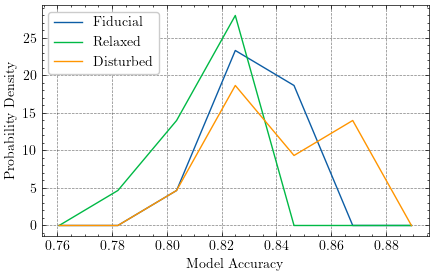

In [26]:
filename = 'pickles/dynamics.pkl'
accuracies = pkl.load(open(filename, 'rb'))
labels = ['Fiducial','Relaxed','Disturbed']
bins = np.linspace(0.75,0.9,8)
fig = plt.figure(figsize=(5,3))
ax = plt.gca()

for i, iAcc in enumerate(accuracies):
    y, x = np.histogram(iAcc,bins=bins, density=True)
    xc = 0.5*(x[:-1]+x[1:])
    ax.plot(xc, y, label=labels[i])
    
    
    
ax.legend(loc=2)
ax.set_ylabel('Probability Density')
ax.set_xlabel('Model Accuracy')
plot_file = "../plots/dynamics.pdf"
plt.savefig(plot_file)
os.system("pdfcrop %s %s" % (plot_file, plot_file))

### Now see if i train on merging does the X-ray help here?

In [17]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
channels = ['total','stellar','xray']
data_file = 'pickles/binned_data_20.pkl'
epochs = 40
nClasses = len(simulationNames)

In [ ]:
train, test, params = getGenerators_meta(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile=data_file,
                                                      return_test_params=True,
                                                        dynamical_state='merging')
fiducial = simpleCNN.getModel_ds(nClasses)
fiducial_history = fiducial.fit(
  x=train,
  validation_data=test,
  epochs=epochs
)

merging_train, merging_test, params = getGenerators_meta(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar'], 
                                                      allDataFile=data_file,
                                                      return_test_params=True,
                                                        dynamical_state='merging')
merging = simpleCNN.getModel_ds(nClasses)
merging_history = merging.fit(
  x=merging_train,
  validation_data=merging_test,
  epochs=epochs
)


In [21]:
models =[fiducial, merging ]
savethese = [ i.history.history for i in models ]
pkl.dump(savethese, open("pickles/dynamical_state_check.pkl","wb"))

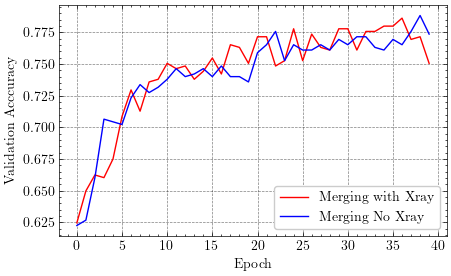

In [22]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')
models = pkl.load(open("pickles/dynamical_state_check.pkl","rb"))

c = ['r','b','g','c','y','k']
names = ['Merging with Xray','Merging No Xray']
for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label=names[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
plt.savefig("../plots/dynmical_state.pdf")

# This is old cold i dont want to use

In [2]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor

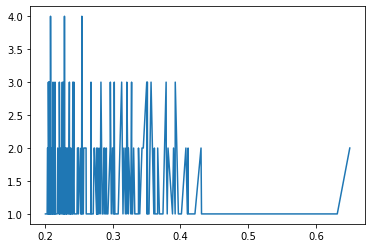

In [60]:
#How correlated are each re-sample? I.e. how many times does the same cluster appear in a re-sample of the test set?
testIDs = None

for i in range(10):
    (train_images, train_labels), testSets = getData( nTest=100, dynamic='relaxed', indexFile='pickles/testIndexesRelaxed_%i.pkl' % i)
    if testIDs is None:
        testIDs = testSets[0.1]['xrayConc']
    else:
        testIDs = np.append(testIDs, testSets[0.1]['xrayConc'])
unique, count = np.unique(testIDs, return_counts=True)
plt.plot(unique, count)

In [ ]:
relaxedCNN = models.load_model('pickles/saveCNNmodel_relaxed.h5')
mergingCNN = models.load_model('pickles/saveCNNmodel_merging.h5')
allCNN = models.load_model('pickles/saveCNNmodel_all.h5')

In [8]:
stats = {'loss':{}, 'accuracy':{}}

for dynamic in ['all','relaxed','merging']:
    stats['loss'][dynamic] = []
    stats['accuracy'][dynamic] = []
    for iMonteCarlo in range(10): #Number of test train resamples
        (train_images, train_labels), testSets = \
                getData( nTest=100, dynamic=dynamic, \
                indexFile='pickles/testIndexes_%s_%i.pkl' % (dynamic, iMonteCarlo))
            
        test_labels, test_images = None, None

        for iKey in testSets.keys():
            if test_labels is None:
                test_images = testSets[iKey]['images']
                test_labels = testSets[iKey]['labels']
            else:
                test_labels = np.vstack((test_labels, testSets[iKey]['labels']))
                test_images = np.vstack((test_images, testSets[iKey]['images']))
                    
        class_names, counts = np.unique(train_labels, return_counts=True)
        modelName = 'pickles/saveCNNmodel_%s_%i.h5' % (dynamic, iMonteCarlo)
        
        CNN = models.load_model(modelName)
        loss, accuracy = CNN.evaluate( test_images, test_labels)
        stats['loss'][dynamic].append(loss)
        stats['accuracy'][dynamic].append(accuracy)

8/8 [==============================] - 0s 48ms/step - loss: 1.2064 - accuracy: 0.8103


0.7369999945163727 0.050478706305127824
0.7588866114616394 0.02489028379614015
0.8397052347660064 0.016357202205200403


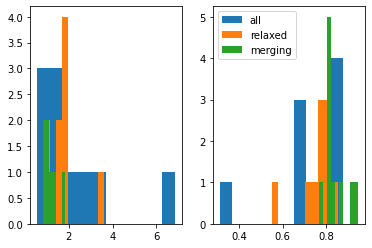

In [17]:
fig, axarr = plt.subplots(1, 2)
for dynamic in ['all','relaxed','merging']:
    axarr[0].hist(stats['loss'][dynamic], label=dynamic)
    axarr[1].hist(stats['accuracy'][dynamic], label=dynamic)
    print(np.mean(stats['accuracy'][dynamic]), np.std(stats['accuracy'][dynamic])/np.sqrt(10.))
plt.legend()